# Problem 1

In [1]:
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
import math
import sklearn.metrics as metrics

In [2]:
# Load MNIST
f = gzip.open('data/mnist.pkl.gz') 
mnist = pickle.load(f, encoding='latin1')

In [3]:
mnist_train_features = mnist[0][0] #(50000,784)
mnist_train_labels = mnist[0][1]   #(50000,1)

mnist_valid_features = mnist[1][0] #(10000,784)
mnist_valid_labels = mnist[1][1]   #(50000,1)

mnist_test_features = mnist[2][0]  #(10000,784)
mnist_test_labels = mnist[2][1]    #(50000,1)

In [4]:
# Reduce the dataset size for testing, if needed (ex: X_train = mnist_train_features[0:10000])
X_train = mnist_train_features[0:1000]
y_train = mnist_train_labels[0:1000]

X_valid = mnist_valid_features[0:100]
y_valid = mnist_valid_labels[0:100]

X_test = mnist_test_features[0:100]
y_test = mnist_test_labels[0:100]

In [16]:
np.argmax([[1,2,3],[3,2,1],[1,3,2]], axis=1)

array([2, 0, 1], dtype=int64)

## Building the Model

In [17]:
class NN(object):
    
    def __init__(self,hidden_dims=(1024,2048),weight_mode=None,epochs=10,learning_rate=0.001):
        self.b1 = np.zeros((hidden_dims[0]))
        self.b2 = np.zeros((hidden_dims[1]))
        self.b3 = np.zeros((10))
        
        self.initialize_weights(hidden_dims,weight_mode)
        
        self.learning_rate = learning_rate
        self.epochs = epochs

    def initialize_weights(self,hidden_dims,weight_mode):
        W1_dim = (784, hidden_dims[0])
        W2_dim = (hidden_dims[0], hidden_dims[1])
        W3_dim = (hidden_dims[1], 10)
        
        if weight_mode == "zero":
            self.W1 = np.zeros(W1_dim)
            self.W2 = np.zeros(W2_dim)
            self.W3 = np.zeros(W3_dim)
            
        elif weight_mode == "normal":
            np.random.seed(0)
            self.W1 = np.random.standard_normal(W1_dim)
            self.W2 = np.random.standard_normal(W2_dim)
            self.W3 = np.random.standard_normal(W3_dim)
            
        elif weight_mode == "glorot":
            np.random.seed(0)
            
            d1 = math.sqrt(6.0 / (W1_dim[0] + W1_dim[1]))
            d2 = math.sqrt(6.0 / (W2_dim[0] + W2_dim[1]))
            d3 = math.sqrt(6.0 / (W3_dim[0] + W3_dim[1]))
            
            self.W1 = np.random.uniform(-d1, d1, W1_dim)
            self.W2 = np.random.uniform(-d2, d2, W2_dim)
            self.W3 = np.random.uniform(-d3, d3, W3_dim)
        
        else:
            raise Exception("Unsupported weight_mode value")

    def forward(self,data):
        cache = {}
        
        cache["h0"] = np.copy(data)
        cache["a1"] = np.dot(cache["h0"], self.W1) + self.b1
        cache["h1"] = self.activation(cache["a1"])
        cache["a2"] = np.dot(cache["h1"], self.W2) + self.b2
        cache["h2"] = self.activation(cache["a2"])
        cache["a3"] = np.dot(cache["h2"], self.W3) + self.b3
        cache["h3"] = self.softmax(cache["a3"])
        
        return cache

    def activation(self,data): # RELU
        return np.where(data > 0, data, 0.0)
    
    def activation_derivative(self,data): # RELU derivative
        return np.where(data > 0, 1.0, 0.0)

    def loss(self,data,labels):
        cache = self.forward(data)
        one_hot_truth = np.eye(10)[labels]
        one_hot_pred = np.zeros((shape(data)[0], 10))
        one_hot_pred[np.argmax(cache["h3"], axis=1)] = 1
        log_loss = -np.sum(np.dot(np.where(one_hot_pred==one_hot_truth,1,0).T, np.log(data)), axis=1)
        
        # metrics.log_loss(labels, cache["h3"])
        return  log_loss

    def softmax(self,data): # Numerically stable softmax
        result = np.exp(data - np.max(data, axis=1, keepdims=True))
        result = result / np.sum(result, axis=1, keepdims=True)
        return result

    def backward(self,cache,labels):
        grads = {}

        grads["a3"] = cache["h3"] - np.eye(10)[labels]
        grads["W3"] = np.dot(cache["h2"].T, grads["a3"])
        grads["b3"] = np.sum(grads["a3"], axis=0)
        
        grads["h2"] = np.dot(grads["a3"], self.W3.T)
        grads["a2"] = grads["h2"] * self.activation_derivative(cache["a2"])
        grads["W2"] = np.dot(cache["h1"].T, grads["a2"])
        grads["b2"] = np.sum(grads["a2"], axis=0)
        
        grads["h1"] = np.dot(grads["a2"], self.W2.T)
        grads["a1"] = grads["h1"] * self.activation_derivative(cache["a1"])
        grads["W1"] = np.dot(cache["h0"].T, grads["a1"])
        grads["b1"] = np.sum(grads["a1"], axis=0)
        
        return grads

    def update(self,grads):
        self.b3 -= (self.learning_rate * grads["b3"])
        self.W3 -= (self.learning_rate * grads["W3"])
        self.b2 -= (self.learning_rate * grads["b2"])
        self.W2 -= (self.learning_rate * grads["W2"])
        self.b1 -= (self.learning_rate * grads["b1"])
        self.W1 -= (self.learning_rate * grads["W1"])

    def train(self,data,labels):
        train_info = {}
        train_info["average_losses"] = []
        
        print("Epoch\tAccuracy\tAverage Loss")
        
        for epoch in range(self.epochs): # TODO: implement mini-batch gradient descent
            cache = self.forward(data)
            grads = self.backward(cache,labels)
            self.update(grads)
            
            predictions = np.argmax(cache["h3"], axis=1)
            
            accuracy = np.mean(predictions == labels)
            
            average_loss = self.loss(data, labels)
            train_info["average_losses"].append(average_loss)
            
            print(epoch + 1, "\t", "{0:.4f}".format(accuracy), "\t", "{0:.4f}".format(average_loss))
        
        return train_info

    def test(self, data):
        cache = self.forward(data)
        predictions = cache["h3"].argmax(1).astype(int)
        return predictions


## Initialization

zero
Epoch	Accuracy	Average Loss
1 	 0.0970 	 2.3025
2 	 0.1170 	 2.3025
3 	 0.1170 	 2.3025
4 	 0.1170 	 2.3024
5 	 0.1170 	 2.3024
6 	 0.1170 	 2.3023
7 	 0.1170 	 2.3023
8 	 0.1170 	 2.3022
9 	 0.1170 	 2.3022
10 	 0.1170 	 2.3022

normal
Epoch	Accuracy	Average Loss
1 	 0.0640 	 22.0334
2 	 0.3590 	 27.0206
3 	 0.2170 	 29.0875
4 	 0.1560 	 26.3922
5 	 0.2350 	 28.4294
6 	 0.1760 	 22.9852
7 	 0.3330 	 20.3866
8 	 0.4080 	 14.8187
9 	 0.5640 	 9.0235
10 	 0.7330 	 7.2371

glorot
Epoch	Accuracy	Average Loss
1 	 0.1000 	 2.3091
2 	 0.1230 	 2.2595
3 	 0.1670 	 2.2132
4 	 0.2350 	 2.1691
5 	 0.3150 	 2.1265
6 	 0.4170 	 2.0848
7 	 0.5020 	 2.0435
8 	 0.5560 	 2.0024
9 	 0.5900 	 1.9611
10 	 0.6300 	 1.9198



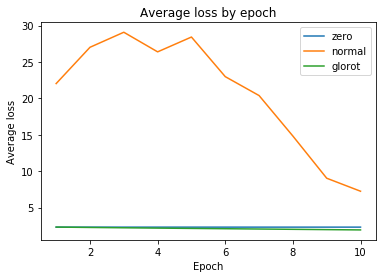

In [6]:
for weight_mode in ["zero", "normal", "glorot"]:
    print(weight_mode)
    nn = NN(hidden_dims=(600,400),weight_mode=weight_mode,epochs=10,learning_rate=0.00005)
    train_info = nn.train(X_train, y_train)
    plt.plot(np.arange(1,11,1), train_info["average_losses"], label=weight_mode)
    print()

plt.title("Average loss by epoch")
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.legend()
plt.show()